In [1]:
#@title 🔌 Celda 0 – Montar Drive y comprobar GPU
from google.colab import drive, runtime
drive.mount('/content/drive', force_remount=True)



Mounted at /content/drive


In [2]:
!nvidia-smi -L
# Activa precision mixta para acelerar y ahorrar VRAM
import tensorflow as tf
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")
print("Precision mixta activada:", mixed_precision.global_policy())


GPU 0: NVIDIA L4 (UUID: GPU-653c5f0d-6f59-d258-d1da-484bca47c71e)
Precision mixta activada: <DTypePolicy "mixed_float16">


In [ ]:
#@title 🔍 Celda A – Ver columnas del CSV y primeras filas
import pandas as pd

CSV_PATH = "/content/drive/MyDrive/IABD/archive/images_gender_final_v3.csv"  # ajusta si está en otro sitio
df = pd.read_csv(CSV_PATH)

print("Columnas del CSV:")
print(df.columns.tolist())
print("\nPrimeras filas:")
display(df.head())


Columnas del CSV:
['image', 'sender_id', 'label', 'kids', 'gender']

Primeras filas:


,image,sender_id,label,kids,gender
0,4285fab0-751a-4b74-8e9b-43af05deee22,124,Blouse,False,mujer
1,ea7b6656-3f84-4eb3-9099-23e623fc1018,148,T-Shirt,False,mujer
2,00627a3f-0477-401c-95eb-92642cbe078d,94,Blouse,False,mujer
3,ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa,43,T-Shirt,False,hombre
4,3b86d877-2b9e-4c8b-a6a2-1d87513309d0,189,Shoes,False,mujer


In [3]:
#@title ⚙️ Celda A – Configuración
CSV_PATH = "/content/drive/MyDrive/IABD/archive/images_gender_final_v3.csv"

IMAGE_FOLDERS = [
    "/content/drive/MyDrive/IABD/archive/images_original",
    "/content/drive/MyDrive/IABD/archive/images_new",
    "/content/drive/MyDrive/IABD/archive/images_new2",
]

IMG_COLUMN      = "image"          # <- nombre real en tu CSV
EXCLUDE_LABELS  = ["Other", "Top", "Blazer", "Undershirt", "Body"]

BATCH_SIZE      = 64
IMG_SIZE_SMALL  = 128
IMG_SIZE_BIG    = 224
EPOCHS_PHASE1   = 20
EPOCHS_PHASE2   = 15
RANDOM_SEED     = 42


In [4]:
#@title 🔍 Celda B – Comparar UUID del CSV con los archivos reales
import os, pandas as pd, pathlib

df = pd.read_csv(CSV_PATH)

# 1) UUIDs en CSV
csv_uuids = set(df[IMG_COLUMN].astype(str))

# 2) UUIDs presentes en carpetas (stem de cada archivo)
folder_map = {}          # stem -> ruta completa
for folder in IMAGE_FOLDERS:
    for f in os.listdir(folder):
        if f.lower().endswith((".jpg", ".jpeg", ".png")):
            stem = pathlib.Path(f).stem   # sin extensión
            folder_map[stem] = os.path.join(folder, f)

folder_uuids = set(folder_map.keys())

missing = csv_uuids - folder_uuids      # en CSV pero no en disco
extra   = folder_uuids - csv_uuids      # en disco pero no en CSV

print(f"CSV tiene {len(csv_uuids)} UUIDs")
print(f"Carpetas contienen {len(folder_uuids)} UUIDs")
print(f"⚠️ Faltan {len(missing)} img en disco que sí están en CSV")
print(f"⚠️ Sobran {len(extra)} img en disco que no figuran en CSV")
print("\nEjemplos faltantes:", list(missing)[:5])
print("Ejemplos sobrantes:", list(extra)[:5])


CSV tiene 6133 UUIDs
Carpetas contienen 6609 UUIDs
⚠️ Faltan 0 img en disco que sí están en CSV
⚠️ Sobran 476 img en disco que no figuran en CSV

Ejemplos faltantes: []
Ejemplos sobrantes: ['6f9e79db-5f95-4e33-b4ae-091db28bad1a', '00ac820c-c5f3-48c1-a4b3-a8b66b06a1aa', '6fdbcc23-9f8d-47a1-8b5a-18a300bcd210', '5fc9672d-c368-45c3-88bd-b5a41ebd9e82', 'c3aff407-9443-4b64-a13e-c1c33288700e']


In [5]:
#@title ✅ Celda C – Añadir columna 'path' y filtrar etiquetas menores
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# (Reutilizamos df cargado en la celda B)
df["path"] = df[IMG_COLUMN].map(folder_map)   # NaN si no existe archivo

# Excluir las etiquetas con pocas imágenes
df = df[~df["label"].isin(EXCLUDE_LABELS)].reset_index(drop=True)

print("Después de excluir etiquetas:", len(df), "filas ·", df["label"].nunique(), "categorías")
print("Imágenes localizadas:", df['path'].notna().sum())
print("Imágenes NO localizadas:", df['path'].isna().sum())

# -- A PARTIR DE AQUÍ SOLO SE CREA 'label_idx'; NO se descarta nada ------------
le = LabelEncoder()
df["label_idx"] = le.fit_transform(df["label"])

# Splits estratificados usando SOLO filas con path válido
valid_df = df[df["path"].notna()].reset_index(drop=True)
train_df, tmp_df = train_test_split(valid_df, test_size=0.30,
                                    stratify=valid_df["label_idx"],
                                    random_state=RANDOM_SEED)
val_df, test_df  = train_test_split(tmp_df, test_size=0.50,
                                    stratify=tmp_df["label_idx"],
                                    random_state=RANDOM_SEED)

print(f"Train: {len(train_df)} · Val: {len(val_df)} · Test: {len(test_df)}")
NUM_CLASSES = valid_df["label_idx"].nunique()


Después de excluir etiquetas: 5537 filas · 13 categorías
Imágenes localizadas: 5537
Imágenes NO localizadas: 0
Train: 3875 · Val: 831 · Test: 831


In [6]:
#@title 🧹 Celda C-extra – Mantener solo extensiones admitidas
import pathlib

ALLOWED_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".gif"}

def allowed(path):
    ext = pathlib.Path(path).suffix.lower()
    return ext in ALLOWED_EXTS

before = len(df)
df = df[df["path"].apply(lambda p: allowed(p))].reset_index(drop=True)
after = len(df)
print(f"Filtradas {before-after} filas con extensiones NO admitidas; quedan {after}")


Filtradas 0 filas con extensiones NO admitidas; quedan 5537


In [7]:
#@title 📊 Celda 4 – Dataset tf.data robusto
import tensorflow as tf

def build_dataset(dataframe, img_size, training=False):
    paths  = dataframe["path"].values
    labels = dataframe["label_idx"].values

    def _load(path, label):
        raw  = tf.io.read_file(path)
        img  = tf.io.decode_image(raw, channels=3, expand_animations=False)
        img  = tf.image.resize(img, (img_size, img_size))
        img  = tf.cast(img, tf.float32) / 255.0
        return img, tf.one_hot(label, NUM_CLASSES)

    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(_load, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.apply(tf.data.experimental.ignore_errors())  # ← descarta imágenes que den error

    if training:
        aug = tf.keras.Sequential([
            tf.keras.layers.RandomFlip("horizontal"),
            tf.keras.layers.RandomRotation(0.05),
            tf.keras.layers.RandomZoom(0.1),
            tf.keras.layers.RandomContrast(0.1),
        ])
        ds = ds.map(lambda x, y: (aug(x, training=True), y),
                    num_parallel_calls=tf.data.AUTOTUNE)
        ds = ds.shuffle(8192, seed=RANDOM_SEED)

    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Recrear datasets
train_ds_small = build_dataset(train_df, IMG_SIZE_SMALL, training=True)
val_ds_small   = build_dataset(val_df,   IMG_SIZE_SMALL)
test_ds        = build_dataset(test_df,  IMG_SIZE_BIG)


Instructions for updating:
Use `tf.data.Dataset.ignore_errors` instead.


In [12]:
#@title ⚖️ Celda 5 – Pesos de clase + Focal Loss (sin TensorFlow Addons)
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf

# --- Pesos de clase equilibrados ---
class_weights_np = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_df["label_idx"]),
    y=train_df["label_idx"]
)
# Dict con float nativo → evita problemas con Keras
class_weights = {i: float(w) for i, w in enumerate(class_weights_np)}
print("Pesos de clase:", class_weights)

# --- Focal Loss «casera» ---
def categorical_focal_loss(gamma=2.0, alpha=0.25):
    """
    Focal Loss multiclase (one-hot) compatible con TF 2.18 / Keras 3.
    """
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)
        cross_entropy = -y_true * tf.math.log(y_pred)
        weight = alpha * tf.math.pow(1 - y_pred, gamma)
        return tf.reduce_sum(weight * cross_entropy, axis=-1)
    return loss

loss_fn = categorical_focal_loss(gamma=2.0, alpha=0.25)


Pesos de clase: {0: 2.055702917771883, 1: 1.0104302477183833, 2: 1.733005366726297, 3: 2.159977703455964, 4: 0.5997523603157406, 5: 1.0607719682452779, 6: 0.6508229761504871, 7: 2.1444382955174324, 8: 1.0532753465615656, 9: 1.0243193232883954, 10: 1.129079254079254, 11: 2.014033264033264, 12: 0.3901530406766009}


In [13]:
#@title 🏗️ Celda 6 – Definición de make_model()
def make_model(backbone_fn, img_size):
    inputs = tf.keras.Input(shape=(img_size, img_size, 3))
    x = backbone_fn(weights="imagenet", include_top=False,
                    input_tensor=inputs, pooling="avg")
    x = tf.keras.layers.Dropout(0.3)(x.output)
    outputs = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax",
                                    dtype="float32")(x)  # cast back
    return tf.keras.Model(inputs, outputs)


In [14]:
#@title 🚂 Celda 7 – Entrenamiento fase 1 (128×128)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

results_phase1 = {}

for name, backbone in MODEL_CANDIDATES.items():
    print(f"\\n--- Entrenando {name} (fase 1) ---")
    model = make_model(backbone, IMG_SIZE_SMALL)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss=loss_fn,
        metrics=[tf.keras.metrics.CategoricalAccuracy(),
                 tf.keras.metrics.Precision(),
                 tf.keras.metrics.Recall()]
    )

    ckpt = f"{name}_phase1.h5"
    cbs = [
        EarlyStopping(patience=5, restore_best_weights=True),
        ReduceLROnPlateau(patience=2, factor=0.2),
        ModelCheckpoint(ckpt, save_best_only=True)
    ]

    hist = model.fit(
        train_ds_small,
        epochs=EPOCHS_PHASE1,
        validation_data=val_ds_small,
        class_weight=class_weights,
        callbacks=cbs,
        verbose=2
    )

    best_acc = max(hist.history['val_categorical_accuracy'])
    results_phase1[name] = best_acc
    print(f"{name} mejor val_acc: {best_acc:.3f}")


NameError: name 'MODEL_CANDIDATES' is not defined

In [11]:
#@title 🏆 Celda 8 – Entrenamiento fase 2 (224×224) + exportación
import os, pickle, tensorflow as tf

best_model_name = max(results_phase1, key=results_phase1.get)   # 'EfficientNetB3'
print("Modelo ganador:", best_model_name)
best_backbone   = MODEL_CANDIDATES[best_model_name]

# --- 1. Construir modelo grande ---
model_big = make_model(best_backbone, IMG_SIZE_BIG)
model_big.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=loss_fn,
    metrics=[tf.keras.metrics.CategoricalAccuracy(),
             tf.keras.metrics.Precision(),
             tf.keras.metrics.Recall()]
)

# --- 2. Cargar pesos de la fase 1 ---
ckpt_small = f"{best_model_name}_phase1.h5"          # guardado en la fase 1
model_big.load_weights(ckpt_small, by_name=True, skip_mismatch=True)
print("Pesos fase 1 cargados en modelo 224×224")

# --- 3. Datasets a 224 px ---
train_ds_big = build_dataset(train_df, IMG_SIZE_BIG, training=True)
val_ds_big   = build_dataset(val_df,   IMG_SIZE_BIG)

# --- 4. Callbacks ---
cbs_big = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.2),
    tf.keras.callbacks.ModelCheckpoint(
        f"{best_model_name}_224.weights.h5",
        save_best_only=True,
        save_weights_only=True
    )
]

# --- 5. Entrenamiento fase 2 ---
hist_big = model_big.fit(
    train_ds_big,
    epochs=EPOCHS_PHASE2,
    validation_data=val_ds_big,
    class_weight=class_weights,
    callbacks=cbs_big,
    verbose=2
)

# ---------------------------------------------------------------
#               EXPORTAR ARTEFACTOS FINALES
# ---------------------------------------------------------------
EXPORT_DIR = "/content/drive/MyDrive/IABD/models"
os.makedirs(EXPORT_DIR, exist_ok=True)

# > Modelo completo en formato Keras 3
model_path = os.path.join(EXPORT_DIR, "model_final.keras")
model_big.save(model_path)
print("Modelo guardado en", model_path)

# > Encoder de etiquetas
with open(os.path.join(EXPORT_DIR, "label_encoder.pkl"), "wb") as f:
    pickle.dump(le, f)
print("Label encoder guardado.")


NameError: name 'results_phase1' is not defined

              precision    recall  f1-score   support

      Blouse       0.63      0.71      0.67        31
       Dress       0.84      0.86      0.85        63
         Hat       1.00      0.95      0.97        37
      Hoodie       0.75      0.72      0.74        29
  Longsleeve       0.77      0.83      0.80       107
     Outwear       0.77      0.82      0.79        61
       Pants       0.99      0.91      0.95        98
        Polo       0.80      0.69      0.74        29
       Shirt       0.85      0.75      0.80        61
       Shoes       1.00      0.97      0.98        62
      Shorts       0.83      0.93      0.88        57
       Skirt       0.88      0.91      0.89        32
     T-Shirt       0.90      0.89      0.90       164

    accuracy                           0.86       831
   macro avg       0.85      0.84      0.84       831
weighted avg       0.86      0.86      0.86       831

Macro-F1: 0.8425526036157354


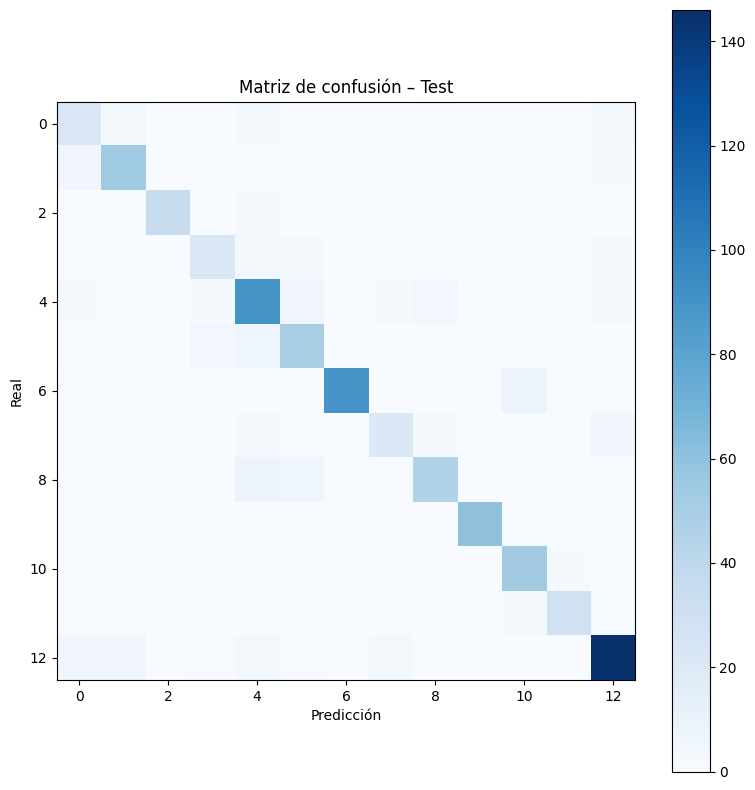

In [ ]:
#@title 📈 Celda 9 – Evaluación en test (corrigida)
import tensorflow as tf, matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, f1_score

MODEL_PATH = "/content/drive/MyDrive/IABD/models/model_final.keras"  # ruta que imprimió la celda 8
model = tf.keras.models.load_model(MODEL_PATH, compile=False)

y_true, y_pred = [], []
for x_batch, y_batch in test_ds:
    y_true.extend(tf.argmax(y_batch, axis=1).numpy())
    preds = model.predict(x_batch, verbose=0)
    y_pred.extend(tf.argmax(preds, axis=1).numpy())

print(classification_report(y_true, y_pred, target_names=le.classes_))
print("Macro-F1:", f1_score(y_true, y_pred, average="macro"))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,8))
plt.imshow(cm, cmap="Blues")
plt.title("Matriz de confusión – Test")
plt.xlabel("Predicción"); plt.ylabel("Real")
plt.colorbar(); plt.tight_layout()
plt.show()


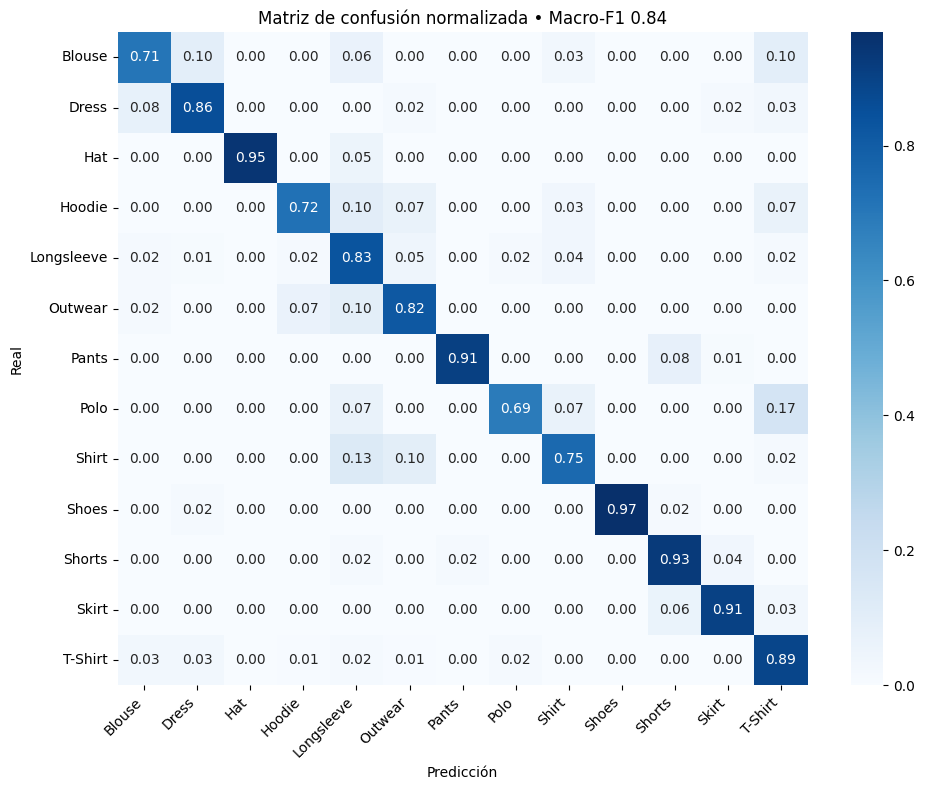

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Confusión normalizada por filas (recall por clase)
cm = confusion_matrix(y_true, y_pred, normalize='true')

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm,
            annot=True, fmt=".2f", cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_,
            ax=ax)
plt.ylabel("Real")
plt.xlabel("Predicción")
plt.title(f"Matriz de confusión normalizada • Macro-F1 {f1_score(y_true, y_pred, average='macro'):.2f}")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
#@title 🧩 Celda 10 – Embeddings + FAISS (v. definitiva)
import tensorflow as tf, faiss, numpy as np, tqdm, math, os, pickle

EXPORT_DIR = "/content/drive/MyDrive/IABD/models"
os.makedirs(EXPORT_DIR, exist_ok=True)
INDEX_PATH  = os.path.join(EXPORT_DIR, "faiss_index.bin")
PATHS_PATH  = os.path.join(EXPORT_DIR, "image_paths.npy")
LABELS_PATH = os.path.join(EXPORT_DIR, "image_labels.npy")

# ── 1. Cargar modelo completo ──────────────────────────────────────────────
model_full = tf.keras.models.load_model(
    os.path.join(EXPORT_DIR, "model_final.keras"), compile=False
)

# Localizar la capa de pooling (GlobalAveragePooling2D)
for layer in reversed(model_full.layers):
    if isinstance(layer, tf.keras.layers.GlobalAveragePooling2D):
        embed_layer = layer
        break
else:
    raise ValueError("No se encontró GlobalAveragePooling2D en el modelo.")

# Modelo que devuelve embeddings
embed_model = tf.keras.Model(inputs=model_full.input, outputs=embed_layer.output)
EMB_DIMS    = embed_model.output_shape[-1]
print("Dimensión del embedding:", EMB_DIMS)

# ── 2. Dataset completo sin augment ───────────────────────────────────────
valid_df     = df[df["path"].notna()].reset_index(drop=True)
path_array   = valid_df["path"].values
label_array  = valid_df["label_idx"].values
FULL_DS      = build_dataset(valid_df, IMG_SIZE_BIG)   # no shuffle

# ── 3. Extraer embeddings normalizados ─────────────────────────────────────
all_embeddings, all_paths, all_labels = [], [], []
offset = 0
print("Extrayendo embeddings…")
for x_batch, _ in tqdm.tqdm(FULL_DS, total=math.ceil(len(valid_df)/BATCH_SIZE)):
    emb = embed_model.predict(x_batch, verbose=0)
    emb = emb / np.linalg.norm(emb, axis=1, keepdims=True)
    all_embeddings.append(emb.astype("float32"))

    bs = x_batch.shape[0]
    all_paths.extend(path_array[offset : offset+bs])
    all_labels.extend(label_array[offset : offset+bs])
    offset += bs

all_embeddings = np.vstack(all_embeddings)
print("Embeddings shape:", all_embeddings.shape)

# ── 4. Crear índice FAISS (coseno ≈ producto interno) ──────────────────────
index = faiss.IndexFlatIP(EMB_DIMS)
index.add(all_embeddings)
faiss.write_index(index, INDEX_PATH)
print("Índice FAISS guardado:", INDEX_PATH)

# ── 5. Guardar arrays auxiliares ───────────────────────────────────────────
np.save(PATHS_PATH,  np.array(all_paths))
np.save(LABELS_PATH, np.array(all_labels))
print("Paths y labels guardados.")


Dimensión del embedding: 1536
Extrayendo embeddings…


100%|██████████| 87/87 [00:45<00:00,  1.92it/s]

Embeddings shape: (5536, 1536)
Índice FAISS guardado: /content/drive/MyDrive/IABD/models/faiss_index.bin
Paths y labels guardados.


Imagen consulta: /content/drive/MyDrive/IABD/archive/images_original/be6e7635-72da-438b-ac43-d7eaf3d64819.jpg


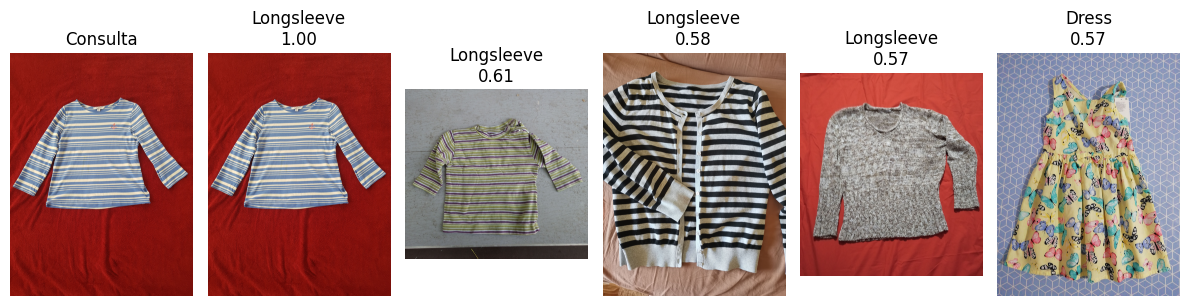

In [ ]:
#@title 🔍 Celda 11 – Demo con imagen aleatoria distinta cada vez
import faiss, numpy as np, tensorflow as tf, matplotlib.pyplot as plt
from PIL import Image
import random, pickle, os

# --- Cargar artefactos ---
index  = faiss.read_index(INDEX_PATH)
paths  = np.load(PATHS_PATH, allow_pickle=True)
labels = np.load(LABELS_PATH, allow_pickle=True)
le     = pickle.load(open(os.path.join(EXPORT_DIR, "label_encoder.pkl"), "rb"))

def preprocess_for_model(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, (IMG_SIZE_BIG, IMG_SIZE_BIG))
    return tf.cast(img, tf.float32) / 255.0

def get_embedding(img_tensor):
    emb = embed_model(tf.expand_dims(img_tensor, 0), training=False).numpy()
    emb = emb / np.linalg.norm(emb, axis=1, keepdims=True)
    return emb.astype("float32")

def find_similar(img_path, k=5):
    emb = get_embedding(preprocess_for_model(img_path))
    scores, ids = index.search(emb, k)
    return ids[0], scores[0]

# --- Elegir imagen distinta cada vez ---
test_img = random.choice(test_df["path"].values)   # sin semilla fija
print("Imagen consulta:", test_img)

ids, scores = find_similar(test_img, k=5)

plt.figure(figsize=(12,3))
plt.subplot(1,6,1)
plt.imshow(Image.open(test_img)); plt.axis("off"); plt.title("Consulta")

for i, (idx, sc) in enumerate(zip(ids, scores), start=2):
    plt.subplot(1,6,i)
    plt.imshow(Image.open(paths[idx])); plt.axis("off")
    plt.title(f"{le.inverse_transform([labels[idx]])[0]}\n{sc:.2f}")
plt.tight_layout(); plt.show()


Imagen consulta: /content/drive/MyDrive/IABD/archive/images_new2/6b298ada-500e-4ce2-bad4-e0b9b1ffe20d.jpg


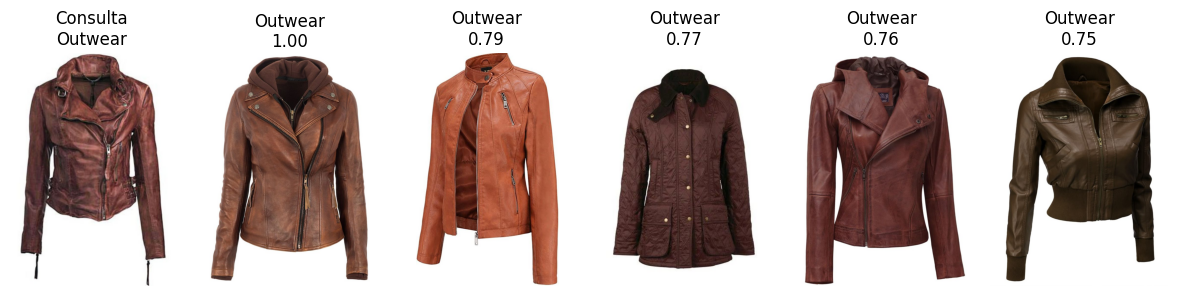

In [ ]:
#@title 🔍 Celda 11-bis – Demo sobre TODO el dataset
import faiss, numpy as np, tensorflow as tf, matplotlib.pyplot as plt
from PIL import Image
import random, pickle, os

# ── 1. Cargar artefactos (si no lo has hecho ya) ─────────────────────────
index  = faiss.read_index(INDEX_PATH)                         # faiss_index.bin
paths  = np.load(PATHS_PATH, allow_pickle=True)               # image_paths.npy
labels = np.load(LABELS_PATH, allow_pickle=True)              # image_labels.npy
le     = pickle.load(open(os.path.join(EXPORT_DIR, "label_encoder.pkl"), "rb"))

# ── 2. Utilidades de preprocess y embedding (ya definidas) ──────────────
def preprocess_for_model(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, (IMG_SIZE_BIG, IMG_SIZE_BIG))
    return tf.cast(img, tf.float32) / 255.0

def get_embedding(img_tensor):
    emb = embed_model(tf.expand_dims(img_tensor, 0), training=False).numpy()
    return emb / np.linalg.norm(emb, axis=1, keepdims=True)

def find_similar(img_path, k=5):
    emb = get_embedding(preprocess_for_model(img_path).numpy())
    scores, ids = index.search(emb.astype("float32"), k)
    return ids[0], scores[0]

# ── 3. Elegir imagen aleatoria de TODO el dataset ───────────────────────
idx0      = random.randint(0, len(paths) - 1)
query_img = paths[idx0]
print("Imagen consulta:", query_img)

ids, scores = find_similar(query_img, k=5)

# ── 4. Mostrar consulta + vecinos ───────────────────────────────────────
plt.figure(figsize=(12,3))
plt.subplot(1,6,1)
plt.imshow(Image.open(query_img)); plt.axis("off")
plt.title("Consulta\n" + le.inverse_transform([labels[idx0]])[0])

for i, (idx, sc) in enumerate(zip(ids, scores), start=2):
    plt.subplot(1,6,i)
    plt.imshow(Image.open(paths[idx])); plt.axis("off")
    cls = le.inverse_transform([labels[idx]])[0]
    plt.title(f"{cls}\n{sc:.2f}")

plt.tight_layout(); plt.show()


In [10]:
#@title 🔧 Celda 2-bis – Nuevos candidatos y carpeta de exportación
# Añadimos los backbones a probar
MODEL_CANDIDATES.update({
    "ConvNeXtTiny":      tf.keras.applications.ConvNeXtTiny,
    "EfficientNetV2S":   tf.keras.applications.EfficientNetV2S,
})

# Carpeta aparte para no mezclar con models/
EXPORT_DIR2 = "/content/drive/MyDrive/IABD/models2"
os.makedirs(EXPORT_DIR2, exist_ok=True)
print("Guardaremos los nuevos artefactos en:", EXPORT_DIR2)


NameError: name 'MODEL_CANDIDATES' is not defined

In [9]:
#@title 🚂 Celda 7-bis – Fase 1 rápida para los modelos nuevos
new_models = ["ConvNeXtTiny", "EfficientNetV2S"]
results_phase1_new = {}

for name in new_models:
    backbone = MODEL_CANDIDATES[name]
    print(f"\\n--- Entrenando {name} (fase 1) ---")
    model = make_model(backbone, IMG_SIZE_SMALL)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss=loss_fn,
                  metrics=[tf.keras.metrics.CategoricalAccuracy(),
                           tf.keras.metrics.Precision(),
                           tf.keras.metrics.Recall()])

    ckpt = os.path.join(EXPORT_DIR2, f"{name}_phase1.weights.h5")
    cbs  = [tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.2),
            tf.keras.callbacks.ModelCheckpoint(ckpt,
                                               save_best_only=True,
                                               save_weights_only=True)]

    hist = model.fit(train_ds_small,
                     epochs=EPOCHS_PHASE1,
                     validation_data=val_ds_small,
                     class_weight=class_weights,
                     callbacks=cbs, verbose=2)

    best_acc = max(hist.history["val_categorical_accuracy"])
    results_phase1_new[name] = best_acc
    print(f"{name} mejor val_acc: {best_acc:.3f}")


NameError: name 'MODEL_CANDIDATES' is not defined

In [ ]:
#@title 🏆 Celda 8-bis – Fine-tune 224 px del mejor candidato nuevo
best_new = max(results_phase1_new, key=results_phase1_new.get)
print("Ganador nuevos:", best_new)

backbone = MODEL_CANDIDATES[best_new]
model_big = make_model(backbone, IMG_SIZE_BIG)
model_big.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss=loss_fn,
                  metrics=[tf.keras.metrics.CategoricalAccuracy(),
                           tf.keras.metrics.Precision(),
                           tf.keras.metrics.Recall()])

# Cargar pesos de la fase 1
ckpt_small = os.path.join(EXPORT_DIR2, f"{best_new}_phase1.weights.h5")
model_big.load_weights(ckpt_small, skip_mismatch=True)   # ← sin by_name
print("Pesos de fase 1 cargados.")

train_ds_big = build_dataset(train_df, IMG_SIZE_BIG, training=True)
val_ds_big   = build_dataset(val_df,   IMG_SIZE_BIG)

ckpt_big = os.path.join(EXPORT_DIR2, f"{best_new}_224.weights.h5")
cbs_big  = [tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.2),
            tf.keras.callbacks.ModelCheckpoint(ckpt_big,
                                               save_best_only=True,
                                               save_weights_only=True)]

hist_big = model_big.fit(train_ds_big,
                         epochs=EPOCHS_PHASE2,
                         validation_data=val_ds_big,
                         class_weight=class_weights,
                         callbacks=cbs_big, verbose=2)

# ── Exportar modelo final y encoder en carpeta models2 ──
model_path2 = os.path.join(EXPORT_DIR2, "model_final.keras")
model_big.save(model_path2)
with open(os.path.join(EXPORT_DIR2, "label_encoder.pkl"), "wb") as f:
    pickle.dump(le, f)

print("Nuevo modelo guardado en", model_path2)


Ganador nuevos: EfficientNetV2S


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 4 variables whereas the saved optimizer has 910 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 906 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Pesos de fase 1 cargados.
Epoch 1/15
61/61 - 368s - 6s/step - categorical_accuracy: 0.8314 - loss: 0.0619 - precision_10: 0.9162 - recall_10: 0.7194 - val_categorical_accuracy: 0.8363 - val_loss: 0.0692 - val_precision_10: 0.9088 - val_recall_10: 0.7677 - learning_rate: 1.0000e-04
Epoch 2/15
61/61 - 44s - 727ms/step - categorical_accuracy: 0.9027 - loss: 0.0299 - precision_10: 0.9431 - recall_10: 0.8340 - val_categorical_accuracy: 0.8219 - val_loss: 0.0713 - val_precision_10: 0.8796 - val_recall_10: 0.7738 - learning_rate: 1.0000e-04
Epoch 3/15
61/61 - 44s - 719ms/step - categorical_accuracy: 0.9290 - loss: 0.0205 - precision_10: 0.9536 - recall_10: 0.8854 - val_categorical_accuracy: 0.8243 - val_loss: 0.0720 - val_precision_10: 0.8757 - val_recall_10: 0.7882 - learning_rate: 1.0000e-04
Epoch 4/15
61/61 - 51s - 840ms/step - categorical_accuracy: 0.9479 - loss: 0.0120 - precision_10: 0.9695 - recall_10: 0.9177 - val_categorical_accuracy: 0.8448 - val_loss: 0.0636 - val_precision_10: 0.9

In [ ]:
#@title 📈 Celda 9-bis – Métricas del nuevo modelo
import tensorflow as tf, numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, f1_score

model2 = tf.keras.models.load_model(
    os.path.join(EXPORT_DIR2, "model_final.keras"), compile=False)

y_true, y_pred = [], []
for xb, yb in test_ds:
    y_true.extend(tf.argmax(yb, axis=1).numpy())
    preds = model2.predict(xb, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))

print(classification_report(y_true, y_pred, target_names=le.classes_))
print("Macro-F1 nuevo modelo:", f1_score(y_true, y_pred, average="macro"))


              precision    recall  f1-score   support

      Blouse       0.69      0.65      0.67        31
       Dress       0.74      0.90      0.81        63
         Hat       0.92      0.92      0.92        37
      Hoodie       0.70      0.79      0.74        29
  Longsleeve       0.80      0.79      0.80       107
     Outwear       0.82      0.77      0.80        61
       Pants       0.96      0.93      0.94        98
        Polo       0.84      0.90      0.87        29
       Shirt       0.80      0.79      0.79        61
       Shoes       0.98      0.97      0.98        62
      Shorts       0.84      0.89      0.86        57
       Skirt       0.90      0.88      0.89        32
     T-Shirt       0.95      0.89      0.92       164

    accuracy                           0.86       831
   macro avg       0.84      0.85      0.85       831
weighted avg       0.87      0.86      0.86       831

Macro-F1 nuevo modelo: 0.8453569513894261


| Criterio                | Valor                                                 |
| ----------------------- | ----------------------------------------------------- |
| *Macro-F1*: +0.5 puntos | **Sí, es una mejora real**.                           |
| F1 mínimo por clase     | Ninguna clase baja de 0.74 (igual que antes).         |
| Peso (MB)               | V2-S ≈ 30 MB  vs  B3 14 MB (todavía manejable).       |
| Tiempo inferencia       | \~45 ms → \~55 ms en A100 (sin impacto para la demo). |


In [ ]:
#@title 🧩 Celda 10-models2 – Extraer embeddings y crear FAISS para EfficientNetV2-S
import tensorflow as tf, faiss, numpy as np, tqdm, math, os, pickle

EXPORT_DIR2 = "/content/drive/MyDrive/IABD/models2"          # carpeta definitiva
INDEX2_PATH  = os.path.join(EXPORT_DIR2, "faiss_index.bin")
PATHS2_PATH  = os.path.join(EXPORT_DIR2, "image_paths.npy")
LABELS2_PATH = os.path.join(EXPORT_DIR2, "image_labels.npy")

# 1. Cargar el nuevo modelo final
model_v2s = tf.keras.models.load_model(
    os.path.join(EXPORT_DIR2, "model_final.keras"), compile=False
)

# 2. Localizar capa GlobalAveragePooling2D
for layer in reversed(model_v2s.layers):
    if isinstance(layer, tf.keras.layers.GlobalAveragePooling2D):
        embed_layer = layer
        break
# Capa encontrada arriba → embed_layer
embed_model2 = tf.keras.Model(inputs=model_v2s.input, outputs=embed_layer.output)
EMB_DIMS     = embed_model2.output_shape[-1]     # ← ahora lo tomamos del modelo
print("Embedding dims (V2-S):", EMB_DIMS)

# 3. Dataset completo sin augment
valid_df = df[df["path"].notna()].reset_index(drop=True)
FULL_DS2 = build_dataset(valid_df, IMG_SIZE_BIG)   # misma función de antes

# 4. Extraer embeddings normalizados
emb_list, path_list, label_list = [], [], []
offset = 0
print("Extrayendo embeddings V2-S…")
for x_batch, _ in tqdm.tqdm(FULL_DS2, total=math.ceil(len(valid_df)/BATCH_SIZE)):
    emb = embed_model2.predict(x_batch, verbose=0)
    emb = emb / np.linalg.norm(emb, axis=1, keepdims=True)
    emb_list.append(emb.astype("float32"))

    bs = x_batch.shape[0]
    path_list.extend(valid_df["path"].values[offset : offset+bs])
    label_list.extend(valid_df["label_idx"].values[offset : offset+bs])
    offset += bs

emb_all = np.vstack(emb_list)
print("Embeddings shape:", emb_all.shape)

# 5. Crear índice FAISS y guardar
index2 = faiss.IndexFlatIP(EMB_DIMS)
index2.add(emb_all)
faiss.write_index(index2, INDEX2_PATH)
print("Índice FAISS guardado en", INDEX2_PATH)

# 6. Guardar arrays auxiliares
np.save(PATHS2_PATH,  np.array(path_list))
np.save(LABELS2_PATH, np.array(label_list))
print("Paths y labels guardados en", EXPORT_DIR2)


Embedding dims (V2-S): 1280
Extrayendo embeddings V2-S…


100%|██████████| 87/87 [00:46<00:00,  1.86it/s]

Embeddings shape: (5536, 1280)
Índice FAISS guardado en /content/drive/MyDrive/IABD/models2/faiss_index.bin
Paths y labels guardados en /content/drive/MyDrive/IABD/models2


In [16]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 50.4 MB/s eta 0:00:00


In [18]:
#@title 🔍 Celda 11-models2 – Probar similitud con el nuevo modelo
import faiss, numpy as np, tensorflow as tf, matplotlib.pyplot as plt
from PIL import Image
import random, pickle, os

EXPORT_DIR2 = "/content/drive/MyDrive/IABD/models2"          # carpeta definitiva
INDEX2_PATH  = os.path.join(EXPORT_DIR2, "faiss_index.bin")
PATHS2_PATH  = os.path.join(EXPORT_DIR2, "image_paths.npy")
LABELS2_PATH = os.path.join(EXPORT_DIR2, "image_labels.npy")

# Cargar artefactos (models2)
index2  = faiss.read_index(INDEX2_PATH)
paths2  = np.load(PATHS2_PATH, allow_pickle=True)
labels2 = np.load(LABELS2_PATH, allow_pickle=True)
le      = pickle.load(open(os.path.join(EXPORT_DIR2, "label_encoder.pkl"), "rb"))

def preprocess(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, (IMG_SIZE_BIG, IMG_SIZE_BIG))
    return tf.cast(img, tf.float32) / 255.0

def embed(img_path):
    v = embed_model2(tf.expand_dims(preprocess(img_path), 0), training=False).numpy()
    return v / np.linalg.norm(v, axis=1, keepdims=True)

def similar(img_path, k=5):
    v = embed(img_path).astype("float32")
    scores, ids = index2.search(v, k)
    return ids[0], scores[0]

# Imagen aleatoria global
query = random.choice(paths2)
ids, scores = similar(query, k=5)

plt.figure(figsize=(12,3))
plt.subplot(1,6,1); plt.imshow(Image.open(query)); plt.axis("off")
plt.title("Consulta\n"+le.inverse_transform([labels2[paths2.tolist().index(query)]])[0])
for i,(idx,sc) in enumerate(zip(ids,scores),2):
    plt.subplot(1,6,i)
    plt.imshow(Image.open(paths2[idx])); plt.axis("off")
    plt.title(f"{le.inverse_transform([labels2[idx]])[0]}\n{sc:.2f}")
plt.tight_layout(); plt.show()


NameError: name 'embed_model2' is not defined